# Convergence metrics

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from pymoo.algorithms.so_genetic_algorithm import GA
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import get_problem, get_termination
from pymoo.optimize import minimize
from pymoo.performance_indicator.hv import Hypervolume
from pymoo.performance_indicator.igd import IGD
from pymoo.util.running_metric import RunningMetric
from pymoo.visualization.scatter import Scatter
from sklearn.preprocessing import MinMaxScaler

## Single-objective metrics
This is a simple case, we can just print the smallest value in the population.

In [2]:
problem = get_problem("sphere")

algorithm = GA()

res = minimize(problem,
               algorithm,
               termination=('n_gen', 50),
               seed=1,
               save_history=True)

Iterate over the history.

In [3]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

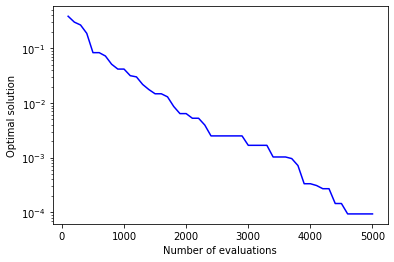

In [4]:
plt.plot(n_evals, opt, "-b")
plt.ylabel("Optimal solution")
plt.xlabel("Number of evaluations")
plt.yscale("log")
plt.show()

# Multi-objective metrics
Let's now consider a multi-objective problem.

In [5]:
problem = get_problem("ZDT1")
pf = problem.pareto_front()

algorithm = NSGA2(pop_size=100, eliminate_duplicates=True)

termination = get_termination("n_gen", 100)

res = minimize(problem,
               algorithm,
               termination,
               seed=1,
               save_history=True,
               verbose=False)

It is possible to plot the best individual in each generation against the number of evaluations. However, the concept of "best individual" in a non-dominated set does not make much sense by definition.

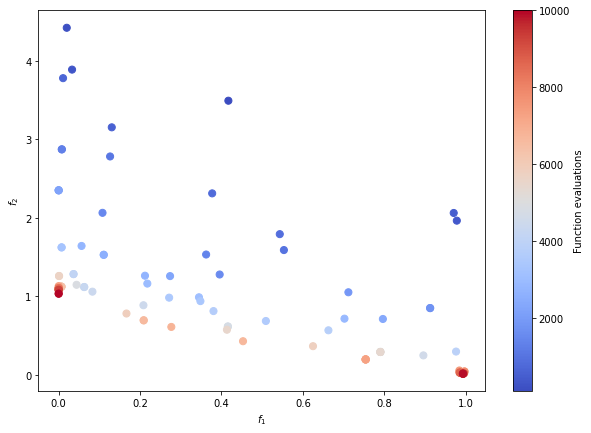

In [6]:
n_evals = np.array([e.evaluator.n_eval for e in res.history])
opt = np.array([e.opt[0].F for e in res.history])

fig = plt.figure(figsize=(10, 7))
plt.scatter(opt[:, 0], opt[:, 1], c=n_evals, s=50, cmap='coolwarm')
cbar = plt.colorbar()
cbar.set_label("Function evaluations")
plt.xlabel(r'$f_1$')
plt.ylabel(r'$f_2$');

We are going to look at some metrics that are more insightful for a multi-objective problem. First, let's plot the non-dominated set of the final generation.

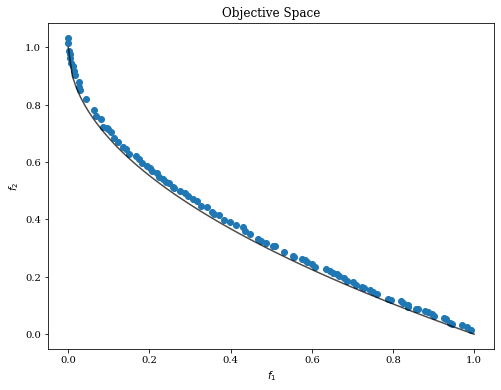

In [7]:
plot = Scatter(title="Objective Space")
plot.add(res.F)
plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show();

Let's extract the population at each generation and plot the first population.

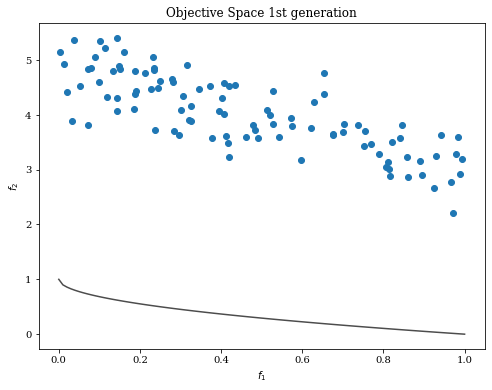

In [8]:
tot_pop = [e.pop.get("F") for e in res.history]

plot = Scatter(title="Objective Space 1st generation")
plot.add(tot_pop[0])
plot.add(pf, plot_type="line", color="black", alpha=0.7)
plot.show();

It is necessary to normalise the objectives before calculating the convergence metrics.

In [9]:
tot_pop = np.vstack(tot_pop)                              # concatenate all the population into 1 array
tot_pop_pf = np.vstack([tot_pop, pf])                     # concatenate the Pareto at the end
scaler = MinMaxScaler()                                   # initialise scaler
tot_pop_pf_norm = scaler.fit_transform(tot_pop_pf)        # fit and transform
F_pf_norm = np.split(tot_pop_pf_norm, 101)                # split array into a list
F_norm, pf_norm = F_pf_norm[:-1], F_pf_norm[-1:]          # seperate normalised population and Pareto front 
pf_norm = pf_norm[0]                                      # convert pf_norm list to array

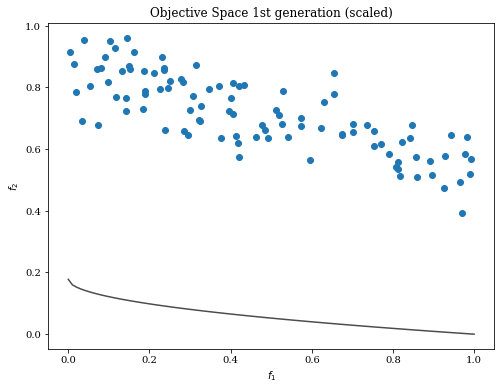

In [10]:
plot = Scatter(title="Objective Space 1st generation (scaled)")
plot.add(F_norm[0])
plot.add(pf_norm, plot_type="line", color="black", alpha=0.7)
plot.show();

## Hypervolume

The hypervolume is the area between the non-dominated solutions and a reference point, which should be chosen carefully. 

![hypervolume](plots/hv.png)
[source](https://pymoo.org/misc/performance_indicator.html)

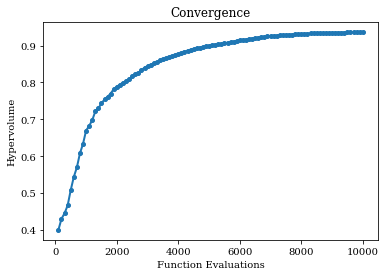

In [11]:
ref_point = np.array([1.0, 1.0])  # this is problem dependent: for this problem [1, 1] is appropriate since we scaled the objectives.

# create the performance indicator object with reference point
metric = Hypervolume(ref_point=ref_point, normalize=False)

# calculate for each generation the HV metric
hv = [metric.calc(f) for f in F_norm]

# visualze the convergence curve
plt.plot(n_evals, hv, '-o', markersize=4, linewidth=2)
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("Hypervolume")
plt.show()

## Inverted Generational Distance (IDG)
For this metric, the Pareto front must be known. For toy problems, such as the one considered here (ZDT1), the Pareto front is known. For real-life problems, it may not be known. In that case, we use an approximation of the Pareto front.

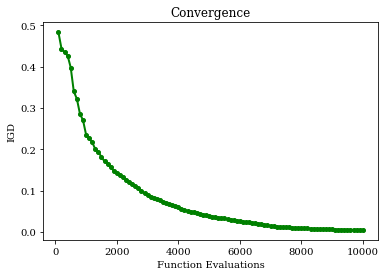

In [12]:
# Initialise the IDG performance indicator
metric = IGD(pf=pf_norm, normalize=False)

# calculate for each generation the HV metric
igd = [metric.calc(f) for f in F_norm]

# visualze the convergence curve
plt.plot(n_evals, igd, '-o', markersize=4, linewidth=2, color="green")
plt.title("Convergence")
plt.xlabel("Function Evaluations")
plt.ylabel("IGD")
plt.show()

## Running metric
The running metric shows the difference in the objective space from one generation to another.

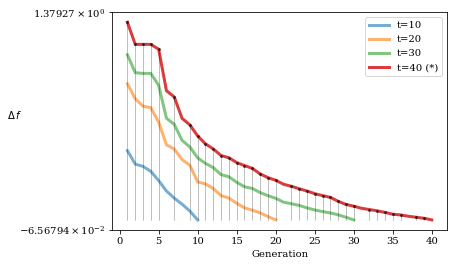

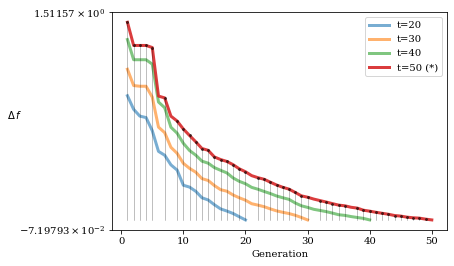

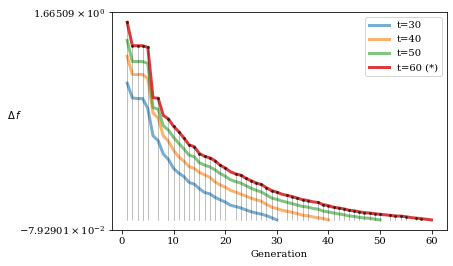

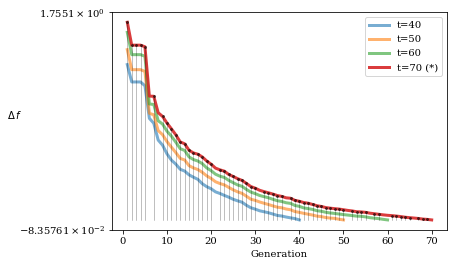

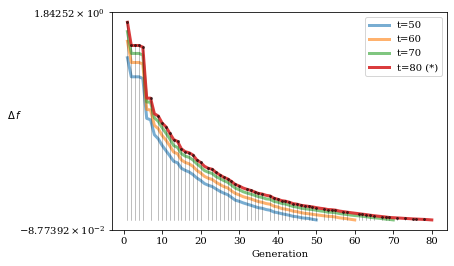

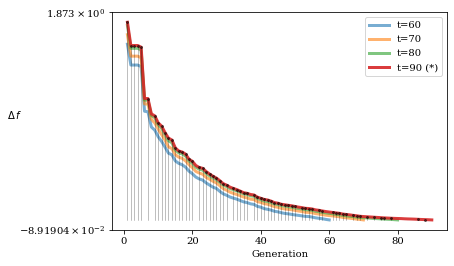

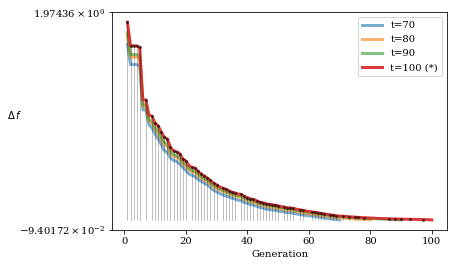

In [13]:
running = RunningMetric(delta_gen=10,
                        n_plots=4,
                        only_if_n_plots=True,
                        key_press=False,
                        do_show=True)

for algorithm in res.history:
    running.notify(algorithm)